In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import io

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [2]:
# --- load master CSV ---
csv = "Data/weather_db.historical_exports_2_23_2026.csv"
master_df = pd.read_csv(csv)

# --- parse per-city CSV ---
df = {}
for _, row in master_df.iterrows():
    city = row['city']
    csv_text = row['csv_content'].replace("\\n", "\n")
    df[city] = pd.read_csv(io.StringIO(csv_text))

# --- choose a city ---
city_name = list(df.keys())[0]
data = df[city_name].copy() # shape (5621, 3)
# columns with 1st example:
    # tempC: 10.1
    # tempF: 50.18
    # timestamp: 2026-02-18T17:05:07.659637-08:00
print(data.shape)

(5621, 3)


In [3]:
data.head()

,tempC,tempF,timestamp
0,10.1,50.18,2026-02-18T17:05:07.659637-08:00
1,10.1,50.18,2026-02-18T17:06:07.653826-08:00
2,10.1,50.18,2026-02-18T17:07:07.722886-08:00
3,10.1,50.18,2026-02-18T17:08:07.759475-08:00
4,10.1,50.18,2026-02-18T17:09:07.679287-08:00


## Preprocess

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values('timestamp')
data = data.set_index('timestamp')
data = data[['tempC']]
# print(data.isna().sum())

### Resample Time Series

In [5]:
print(f"Before:\n{data.index.to_series().diff().value_counts().head()}")
data = data.resample('1min').mean()
data = data.interpolate()
print(f"\nAfter:\n{data.index.to_series().diff().value_counts().head()}")

Before:
timestamp
0 days 00:00:59.934747    2
0 days 00:01:00.018005    2
0 days 00:00:59.957264    2
0 days 00:00:59.981629    2
0 days 00:00:59.989342    2
Name: count, dtype: int64

After:
timestamp
0 days 00:01:00    5694
Name: count, dtype: int64


## Visualize

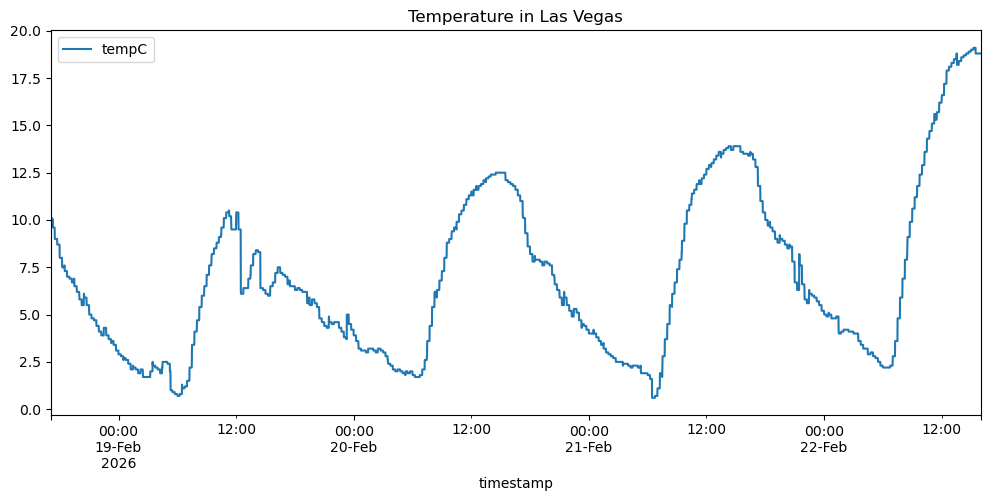

In [6]:
data.plot(figsize=(12,5))
plt.title(f"Temperature in {city_name}")
# plt.show()
plt.savefig('assets/temperature-samples.png')

## Feature Engineering

In [7]:
data['hour'] = data.index.hour
data['dayofyear'] = data.index.dayofyear

data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

data['doy_sin'] = np.sin(2 * np.pi * data['dayofyear'] / 365)
data['doy_cos'] = np.cos(2 * np.pi * data['dayofyear'] / 365)

# Final feature set
features = ['tempC', 'hour_sin', 'hour_cos', 'doy_sin', 'doy_cos']
data = data[features]
data.head()

,tempC,hour_sin,hour_cos,doy_sin,doy_cos
timestamp,,,,,
2026-02-18 17:05:00-08:00,10.1,-0.965926,-0.258819,0.746972,0.664855
2026-02-18 17:06:00-08:00,10.1,-0.965926,-0.258819,0.746972,0.664855
2026-02-18 17:07:00-08:00,10.1,-0.965926,-0.258819,0.746972,0.664855
2026-02-18 17:08:00-08:00,10.1,-0.965926,-0.258819,0.746972,0.664855
2026-02-18 17:09:00-08:00,10.1,-0.965926,-0.258819,0.746972,0.664855


### Scale Data

In [8]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

## Create Sequences for LSTM

In [9]:
def create_sequences(data, seq_length):
    X = []
    y = []

    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # target = tempC only

    return np.array(X), np.array(y)

SEQ_LENGTH = 60 # last 1 hour
X, y = create_sequences(scaled_data, SEQ_LENGTH)

print(X.shape)
# (samples, 60, 5)

(5635, 60, 5)


## Train/Test Split (Time Aware)
Do not shuffle time series

In [10]:
X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1).to(device)

train_size = int(len(X_tensor) * 0.8)

X_train = X_tensor[:train_size]
y_train = y_tensor[:train_size]

X_test = X_tensor[train_size:]
y_test = y_tensor[train_size:]

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

## Define LSTM Model

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=5, hidden_size=64, num_layers=2):
        super(LSTMModel, self).__init__()
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # take last time step
        out = self.fc(out)
        return out

model = LSTMModel().to(device)

## Training

In [12]:
criterion = nn.HuberLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, patience=3, factor=0.5
)

EPOCHS = 100

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()

        outputs = model(xb)
        loss = criterion(outputs, yb)

        loss.backward()

        # Gradient clipping (important)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        train_loss += loss.item()
        
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_test)
        val_loss = criterion(val_preds, y_test).item()

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | " f"Train Loss: {train_loss:.6f} | " f"Val Loss: {val_loss:.6f}")

Epoch 1/100 | Train Loss: 0.023242 | Val Loss: 0.111693
Epoch 2/100 | Train Loss: 0.043712 | Val Loss: 0.096359
Epoch 3/100 | Train Loss: 0.003542 | Val Loss: 0.010311
Epoch 4/100 | Train Loss: 0.003225 | Val Loss: 0.009933
Epoch 5/100 | Train Loss: 0.003465 | Val Loss: 0.009275
Epoch 6/100 | Train Loss: 0.003421 | Val Loss: 0.008713
Epoch 7/100 | Train Loss: 0.003059 | Val Loss: 0.008833
Epoch 8/100 | Train Loss: 0.002758 | Val Loss: 0.009336
Epoch 9/100 | Train Loss: 0.002535 | Val Loss: 0.009216
Epoch 10/100 | Train Loss: 0.002250 | Val Loss: 0.011782
Epoch 11/100 | Train Loss: 0.001400 | Val Loss: 0.005789
Epoch 12/100 | Train Loss: 0.001144 | Val Loss: 0.005761
Epoch 13/100 | Train Loss: 0.001050 | Val Loss: 0.006562
Epoch 14/100 | Train Loss: 0.001031 | Val Loss: 0.007203
Epoch 15/100 | Train Loss: 0.001021 | Val Loss: 0.007674
Epoch 16/100 | Train Loss: 0.001006 | Val Loss: 0.008007
Epoch 17/100 | Train Loss: 0.000789 | Val Loss: 0.004403
Epoch 18/100 | Train Loss: 0.000836 | Va

## Evaluation

In [13]:
model.eval()
with torch.no_grad():
    preds = model(X_test).cpu().numpy()

# Create dummy array for inverse transform
dummy = np.zeros((len(preds), 5))
dummy[:, 0] = preds.flatten()

predictions = scaler.inverse_transform(dummy)[:, 0]

# True values
dummy_true = np.zeros((len(y_test), 5))
dummy_true[:, 0] = y_test.cpu().numpy().flatten()

y_actual = scaler.inverse_transform(dummy_true)[:, 0]

## Plot

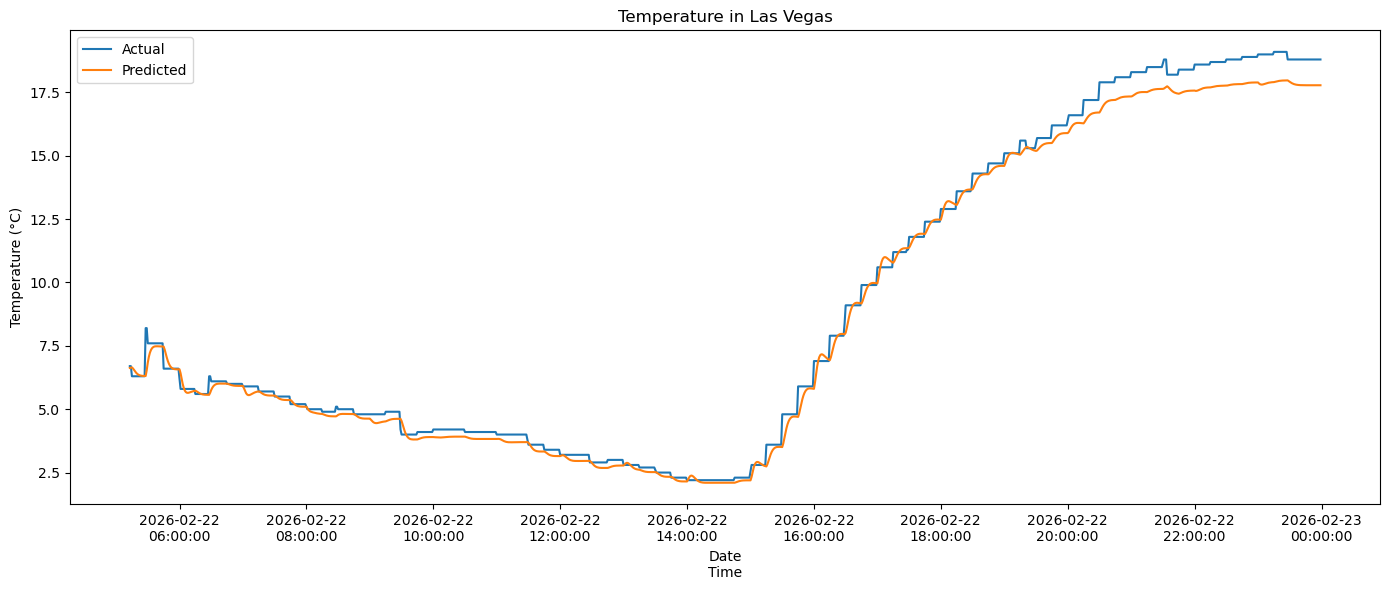

In [14]:
data.index[SEQ_LENGTH]

# Get full index after sequence trimming
all_dates = data.index[SEQ_LENGTH:]

# Split same way as tensors
test_dates = all_dates[train_size:]

import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(14,6))

ax.plot(test_dates, y_actual, label="Actual")
ax.plot(test_dates, predictions, label="Predicted")

ax.set_xlabel("Date\nTime")
ax.set_ylabel("Temperature (°C)")
ax.set_title(f"Temperature in {city_name}")

ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d\n%H:%M:%S'))

plt.legend()
plt.tight_layout()
# plt.show()
plt.savefig('assets/temperature-forecast.png')